# Introduction to Python Ensembles by DataQuest
[source](https://www.dataquest.io/blog/introduction-to-ensembles/)

This tutorial was reproduced base on a piece written by DataQuest, because i believe i will get a better understand on how ensembles work if i go through the motion of producing it. It provides guidance on stacking models. 

I'm still not comfortable with it, will revisit once i find a better form of explanation for the codes in terms of stacking!

[What is an ensemble?](#t1.0)<br>
[A forest is an ensemble of trees](#t2.0)<br>
[Ensembles as averaged predictions](#t3.0)<br>
[Learning to combine predictions](#t4.0)<br>
[Training with cross-validation](#t5.0)<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
np.random.seed(222)

df = pd.read_csv('input.csv')

In [2]:
df.head()

cand_pty_affiliation cand_office_st cand_office cand_status rpt_tp  \
0                  REP             US           P           C     Q3   
1                  DEM             US           P           C     M5   
2                  DEM             US           P           C     M3   
3                  DEM             US           P           C     Q2   
4                  REP             US           P           C    12G   

  transaction_tp entity_tp state classification   cycle  transaction_amt  
0             15       IND    NY       Engineer  2016.0            500.0  
1            15E       IND    OR      Math-Stat  2016.0             50.0  
2             15       IND    TX      Scientist  2008.0            250.0  
3            15E       IND    IN      Math-Stat  2016.0            250.0  
4             15       IND    MA       Engineer  2016.0            184.0

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """" Split data into train and test sets."""
    y = 1*(df.cand_pty_affiliation == 'REP') #to convert rep and dem to 1 & 0
    X = df.drop(['cand_pty_affiliation'], axis =1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis =1, inplace = True)
    return train_test_split(X,y,test_size=test_size, random_state = 222)

xtrain, xtest, ytrain, ytest = get_train_test()

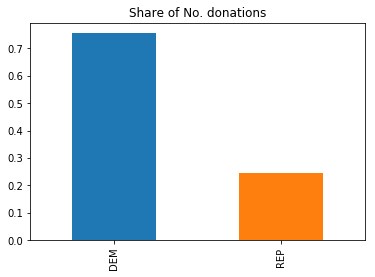

In [4]:
df.cand_pty_affiliation.value_counts(normalize = True).plot(kind = 'bar', title="Share of No. donations")
plt.show()

Between Democrats and Republicans, about 75% of all contributions are made to democrats. Lets go through the features at our disposal. We have data about donor, transaction and recipient. The metric of choice is **ROC-AUC**

<a id="t1.0"></a>
## SO, what is an ensemble?
In a nutshell, combining predictions from several models averages out idiosyncratic errors and yield better overall predictions. But the million dollar question comes down to how to combine predictions? Majority voting is the easy one but there are many other ways to combine predictions, and more generally we can use a model to *learn* how to best combine predictions. Basic ensemble structure would be to feed data to a set of models and a meta learner combine model predictions.

### Lets start simple with ensembles by combining decision trees
The basic gist is that the deeper the tree, the complex the patterns it can capture, but more prone to overfitting it will be. To counter this, we need an alternative way of building complex models of decision trees, and an ensemble of different decision trees is one such way

In [5]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print Decision tree"""
    graph = export_graphviz(
        clf,
        label='root',
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=feature_names,
        class_names={0:"D",1:"R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

Lets fit a decision tree with a single node on our training data and see how it perform on the test set

In [6]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=222) #super simple tree
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:,1]

Decision tree ROC-AUC score: 0.672


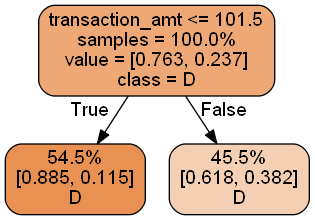

In [7]:
print("Decision tree ROC-AUC score: %.3f"% roc_auc_score(ytest,p))
print_graph(t1, xtrain.columns)

Each of the two leaves register their share of training samples, the class distribution within their share and the class label prediction. This tree bases its prediction on whether the size of the contribution is above 101.5 but it makes the same prediction regardless, which is not surprising given 75% of all donations are to Democrats. Lets create a more complicated tree.

Decision tree ROC-AUC score: 0.751


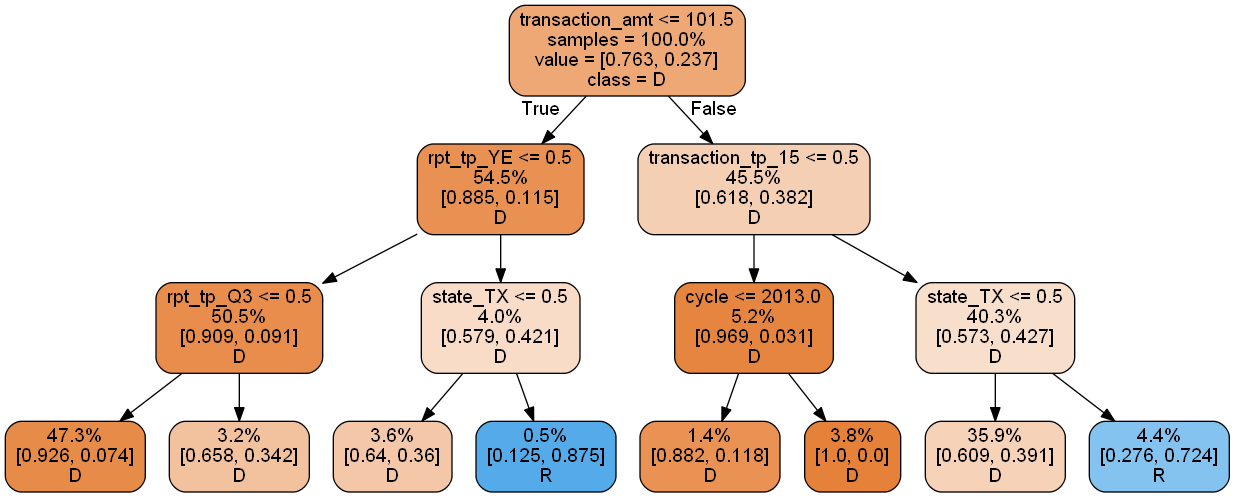

In [8]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=222)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:,1]

print('Decision tree ROC-AUC score: %.3f' % roc_auc_score(ytest,p))
print_graph(t2, xtrain.columns)

Decision tree ROC-AUC score: 0.740


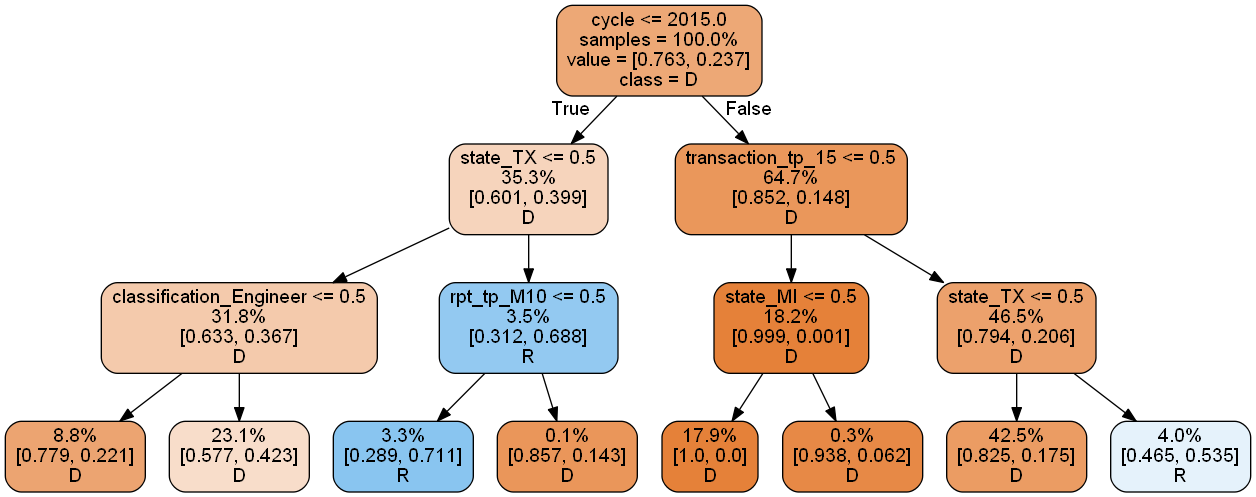

In [9]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=222)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

This model aint better either because only a mere 5% of all donations are predicted to go to Republicans, short of the 25% we would expect. If you pay attention to the lead on the far left and the second from the far right, the vast majority of the observations end up there, with very little in the other leaves. If i were to make it deeper, it will only result in overfitting.

Fixing depth, a decision tree can be made more complex by increasing "width", that is, creating several decision trees and combining them. In other words, an ensemble of decision trees. If we were to remove '*transaction amount*' from the features, it will then choose another feature to split from but the ROC values would be more or less the same. **However**, the Republican donation could increase if the tree splis from another feature. What we have now is 2 different models with similar predictive power BUT operate on different rules. Because of this, they are likely to make different prediction errors.

An ensemble that averages classifier predictions is known as **majority voting classifier**. When an ensemble averages based on probabilities, we refer to it as **soft voting**, averaging final class label predictions is known as **hard voting**. For averaging to work, **prediction errors must be uncorrelated**. If both models made incorrect predictions, the ensemble would not be able to make any corrections. Moreover, in the soft voting scheme, if one model makes an incorrect prediction with a high probability value, the ensemble would be overwhelmed.

<a id="t2.0"></a>
## A forest is an ensemble of trees

In [10]:
p1 = t2.predict_proba(xtest)[:,1] #t2 is trained on normal data
p2 = t3.predict_proba(xtest_slim)[:,1] #t3 is trained on slim data


# looking at the correlation of the data
pd.DataFrame({'full_data': p1,
             'red_data':p2}).corr()

full_data  red_data
full_data   1.000000  0.669128
red_data    0.669128  1.000000

There is some correlation but not overly so, so there's still a good deal of prediction variance to exploit. To build the first ensemble, simply average the two model's predictions

In [11]:
p1 = t2.predict_proba(xtest)[:,1] #t2 is trained on normal data
p2 = t3.predict_proba(xtest_slim)[:,1] #t3 is trained on slim data
p = np.mean([p1,p2], axis = 0)
print('Average of decision tree ROC-AUC score: %.3f'%roc_auc_score(ytest,p))

Average of decision tree ROC-AUC score: 0.783


Look at the score! 0.783 is indeed an improvement from 0.74! What if we add more diverse trees, we could get an even greater gain? A another approach would be to randomly select a subset of features, fit one tree on each draw and average their predictions - **bootstrapped averaging (bagging)** which results in a **Random Forest**

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10, # 10 trees
    max_features=3, #3 features
    random_state= 222
    )

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:,1]
print('Average of decision tree ROC-AUC score: %.3f'%roc_auc_score(ytest,p))

Average of decision tree ROC-AUC score: 0.844


Boom! Random Forest gave us a significant improvement upon our previous models.
<a id="t3.0"></a>
## Ensembles as averaged predictions
### So far...
    * the less correlation in prediction errors, the better
    * the more models, the better

So, its a good idea to use as different models as possible and we've only encountered simply averaging so far...

$$e(x) = {\frac{1}{n}}\sum_{i=1}^n{f_i(x)}$$

You can use whatever models you like, ie decision trees, linear models, kernel based models, non-parametric models, neural networks. Just remember, more models = slower ensemble.

To build an ensemble of various models, lets benchmark a set of scikit learn classifiers on the dataset

In [13]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.pipeline import make_pipeline

def get_models():
    
    """Generate a library of base learners"""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=222)
    nn = MLPClassifier((80,10), early_stopping=False, random_state=222)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=222)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=222)
    
    models = {'svm':svc,
              'knn': knn,
              'naive bayes':nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm':gb,
              'logistic': lr}
    return models

def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models')
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end = " ", flush=False) #prints the name of the model
        m.fit(xtrain, ytrain) #trains the model 
        P.iloc[:,i] = m.predict_proba(xtest)[:,1] #predicts probability and fills the dataframe with predicted values
        cols.append(name) #append name of model to col
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def score_models(P,y):
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:,m]) # getting probabilities generated by a particular model
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [14]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803
mlp-nn                    : 0.873
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.857
Done.



So there you go, our baseline performance. The Gradient Boosting Machine (GBM) does best, followed by mlp-nn. Remember how the prediction errors must be relatively uncorrelated? Lets check it now

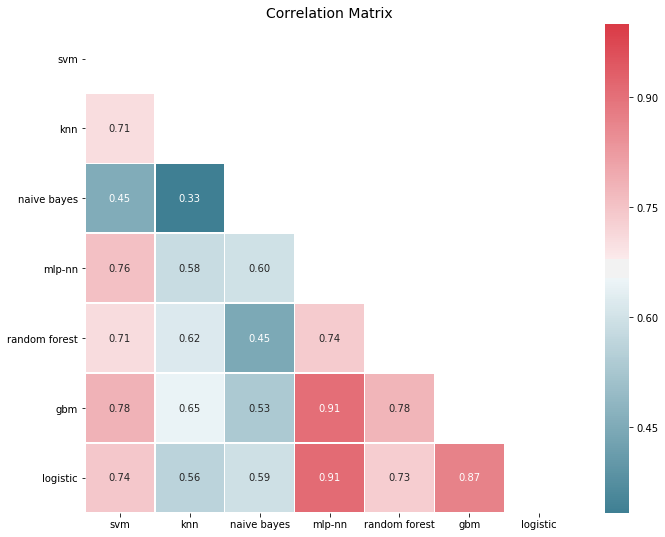

In [15]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

Errors are significantly correlated, which is to be expected for models that perform well, since its typically the outliers that are hard to get right. If we look at error correlations on a class prediction basis things look a little different

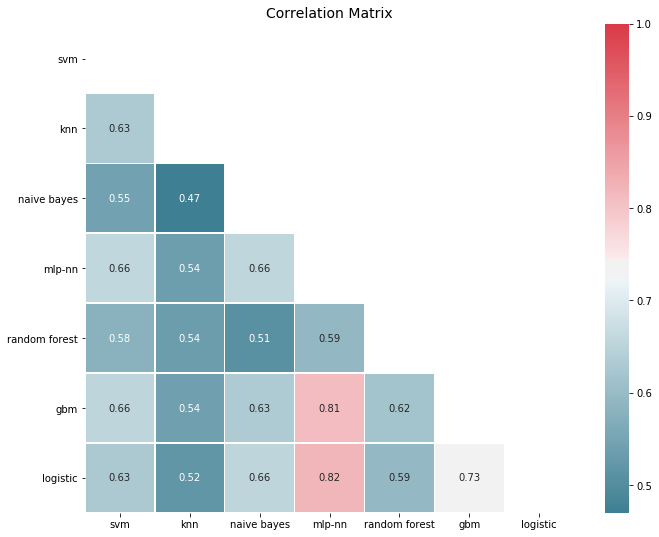

In [23]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate = False)

Lets do an averaging of predictions and we expect it to outperform the baseline.

In [24]:
print('Ensemble ROC-AUC score: %.3f' % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.885


We've understood the power of ensembles as an error correction mechanism. This means that ensembles smooth out decision boundaries by averaging out irregularities. A decision boundary shows us how an estimator carves up feature space into neighborhood within which all observations are predicted to have the same class label. By averaging out base learner decision boundaries, the ensemble is endowed with a smoother boundary that generalize more naturally.

[visualization](https://www.dataquest.io/blog/introduction-to-ensembles/) in the 'visualizing how ensembles work'

### Inspecting ROC
It shows us how an estimator trades off precision and recall. Typically, different base learners make different trade offs: some have higher precision by sacrificing recall, and other have higher recall by sacrificing precision. A non-linear meta learner, on the other hand, is able to, for each training point, adjust which models it relies on. This means that it can significantly reduce necessary sacrifices and retain high precision while increasing recall (or vice versa).

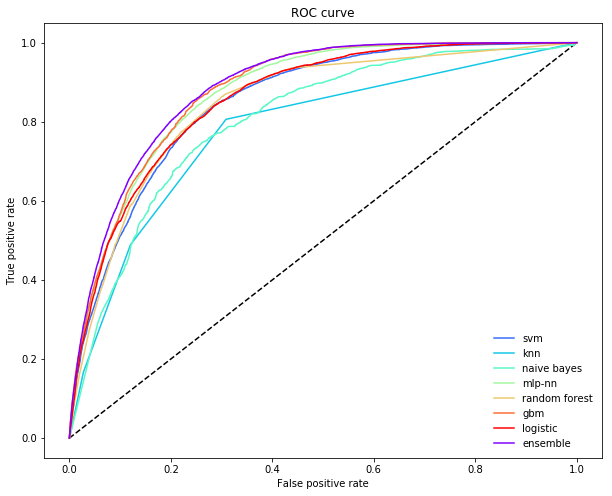

In [46]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble"""
    plt.figure(figsize=(10,8))
    plt.plot([0,1],[0,1], 'k--')
    
    cm = [plt.cm.rainbow(i) for i in np.linspace(0,1.0, P_base_learners.shape[1] + 1)] #P_base_learners.shape[1] = 7 (the cols)
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:,i] # getting the predicted values for each estimator
        fpr, tpr, _=roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])
    
    fpr, tpr, _= roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label = ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()
    
plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

## Beyond ensembles as simple average

Some of the models perform considerably worse than others, yet their influence is just large as better performing models. This can be quite devastating with unbalanced data sets. if a model makes an extreme prediction (i.e close to 0 or 1), that prediction has a strong pull on the prediction average.

Remember how our models only predicted very Republicans? Lets double check that and see if they are still able to capture the full share of Republican donations.

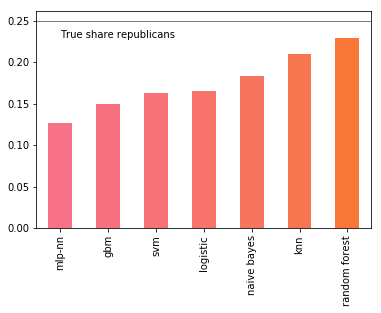

In [52]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize = True))
p.index = ['DEM','REP']
p.loc['REP',:].sort_values().plot(kind = 'bar')
plt.axhline(0.25, color = 'k', linewidth = 0.5)
plt.text(0, 0.23, "True share republicans")
plt.show()

In [53]:
# lets remove the worse offenderm Multilayer Perceptron (MLP)
include = [c for c in P.columns if c not in ['mlp-nn']]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis = 1)))

Truncated ensemble ROC-AUC score: 0.883


Didn't really improve the performance with 0.883...We need a smarter way of prioritizing between models. What we want is to *learn* a sensible set of weights to use when averaging predictions. This turns the ensemble into a parametric model that needs to be trained.

<a id="t4.0"></a>
## Learning to combine predictions
Learning a weighted average means that for each model $f_i$, we have a weight parameter that assigns our weight to that model's predictions. Weighted average requires all weights to sum to 1

$$e(x) = \sum_{i=1}^n{w_i}{f_i(x)}$$

### Implementing an ensemble
1. a library of base learners that generate predictions
2. a meta learner that learns how to best combine these predictions
3. a method for splitting the training data between the base learners and the meta learner

The meta learner is trained on $P base$, which is the different predicted outcomes by all the base learners. The strategy is to generate a prediction matrix $P$ that reflects test errors. The simplest way is to split the full data set $X$ in two, train the base learners on one half and have them predict the other half, which then becomes the input to the meta learner. This way tho, could cause the base learners and meta learner to perform poorly if the dataset is medium to small size. To fix it, we will have to use **cross-validation**, a method initially developed for validating test-set performance during model selection.
Lets get a feel and try one out first!

In [56]:
# Step 1: Define a library of base learners
base_learners = get_models()

# Step 2: define a meta learner. If you choose another ensemble, then you will have a 2 layer ensemble, like a feed forward NN
meta_learner = GradientBoostingClassifier(
                n_estimators=1000,
                loss = 'exponential',
                max_features=4,
                max_depth = 3,
                subsample = 0.5,
                learning_rate = 0.005,
                random_state=222)

# Step 3: define a procedure for generating train and test sets
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(xtrain, ytrain, test_size = 0.5, random_state=222)

Now, we have one training set of the base learners ($X$train_base, $Y$train_base) and one prediction set ($X$ pred_base, $Y$pred_base) and are ready to generate the prediction matrix for the meta learner.

In [57]:
# Step 4: train the base learners on a training set
def train_base_learners(base_learners, inp, out, verbose =True): #verbose is to show more info, don't need if you dont want
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [60]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


#### Step 5: generate base learner predictions
With base learners fitted, we now generate a set of predictions for the meta learner to train on. We generate predictions for observations not used to train the base learners.

In [63]:
def predict_base_learners(pred_base_learners, inp, verbose = True):
    """Generate a prediction matrix"""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))
    
    if verbose: print('Generating base learner predictions')
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:,i] = p[:,1]
        if verbose: print('done')
    return P

In [64]:
# using the trained base learners to predict
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


### Train the meta learner
The prediction matrix is used to train the meta learner. So there you go, to generate a prediction for some observation, we first feed it to the base learners, which outputs a set of predictions that we feed to the meta learner. The meta learner then gives us the ensemble's final prediction

In [65]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=222,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [66]:
# Lets put everything together in a function 
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble"""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:,1]

In [68]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.881


The score of 0.881 doesn't beat our ROC-AUC benchmark of 0.883 previously. Which is expected because we only use half the data to train so there was a lot of information lost! 

<a id="t5.0"></a>
## Training with cross validation
Fitting an ensemble with cross validation is referred to as **stacking**, while the ensemble itself is known as the **Super Learner**. To understand how cross-validation works, we can think of it as an outer loop over our previous ensemble. The outer loop iterates over K distinct test folds, with the remaining data used for training. The inner loop trains the base learners and generate predictions for the held-out data. 

In [71]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking"""
    
    # train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose = False)
    print("Done")
    
    # Generate predictions for training meta learners
    # Outer loop
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):
        
        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]
        
        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model) for name, model in base_learners.items()}
        
        train_base_learners(fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)
        
        fold_P_base = predict_base_learners(fold_base_learners, fold_xtest, verbose=False)
        
        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))
        
    print("CV-predictions done")

    # becareful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)
    
    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print('done')
    
    return base_learners, meta_learner

### Lets break it down step by step
1. fit final base learners on *all* data, in contract with previous blend ensemble, base learners used at test time are trained on all available data
2. Loop over all folds, then loop over all base learners to generate CV predictions
3. These predictions are stacked to build the training set for the meta learner

The basic difference between *blending* and *stacking* is therefore that stacking allows both base learners and the meta learner to train on the full data set. 

In [72]:
from sklearn.model_selection import KFold

cv_base_learners, cv_meta_learner = stacking(get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...Done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889


Stacking yields a sizeable increase in performance: in fact, it gives us our best score so far. This outcome is typical for small and medium-sized data sets, where the effect of blending can be severe. As the data set size increases, blending and stacking performs similarly.b

## Use package to make things simpler

In [75]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=222,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:02:52
Processing layer-2             done | 00:00:06
Fit complete                        | 00:03:00

Predicting 2 layers
Processing layer-1             done | 00:01:21
Processing layer-2             done | 00:00:02
Predict complete                    | 00:01:26

Super Learner ROC-AUC score: 0.890


In [ ]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")

### Building a class to do stacking instead

[Source](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)        

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models) #rmsle_cv is a self define function